<a href="https://colab.research.google.com/github/SangMin316/2022_Dacon_Contest/blob/main/mbti_500_convolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

### Create Variables

In [3]:
txt_size = 400
epochs = 10
mini_batch = 500

## Load Data

In [4]:
df = pd.read_csv("/content/drive/MyDrive/2022 big_data/dataset/MBTI_train.csv",names = ['type','posts'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74357 entries, 0 to 74356
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    74357 non-null  object
 1   posts   74357 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [5]:
df.head()

,type,posts
0,INTP,say process model list like subscriber channel...
1,INFJ,upon much manipulate retail finish like sacrif...
2,INFJ,fit yes certain bff social feel goal go know n...
3,INTJ,complete love within someone ideal joke solvea...
4,ENTJ,public strictly thing person x question person...


In [6]:
X = df['posts'] # features
y = df['type']  # labels

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

###Show data distribution

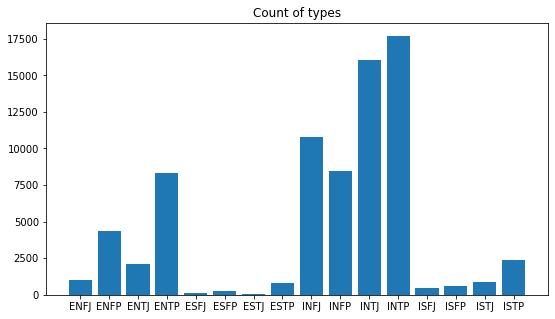

In [16]:
unique_labels, count = np.unique(df['type'], return_counts=True)
fig = plt.figure(figsize=(9,5))
plt.bar(unique_labels, count, width=0.8)
plt.title("Count of types")
plt.savefig('count of types')

We can note inbalance of classes

Some classes are scarce

## vetorize data

In [8]:
X_val = X.values

In [9]:
X_val.shape

(74357,)

In [10]:
def vectorize_text(text, label): 
    text = tf.expand_dims(text, -1) 
    return vectorize_layer(text), label 
# Vectorize the data. 

max_features = 10000
sequence_length = 500

vectorize_layer = TextVectorization(
    max_tokens=max_features, 
    output_mode="int", 
    output_sequence_length=sequence_length,
)
vectorize_layer.adapt(X_val)
vect_train = vectorize_layer(X_val)
# vect_val = vectorize_layer(X_val_values)
# vect_test = vectorize_layer(data_test)

In [11]:
vect_train.shape

TensorShape([74357, 500])

In [12]:
vect_train[0]

<tf.Tensor: shape=(500,), dtype=int64, numpy=
array([  13,  251,  715,  417,    2, 5274, 1797, 3056,  235,  610,  123,
        128,  192,  623,   53,  292,  113,  958, 3441, 1519,  706, 1598,
        103,   28,    5, 2545,  110, 1200,  509,    1,    2,  855,   46,
         68,  141,  479,    3, 2272,  832,  825,   25,  314,  196,    1,
         15, 1640, 1468,  336, 2394,  138,   50,  568,  747, 1864,  273,
          7,   86, 3917,   32,  193,  249,   64, 5462, 2477,   74,  450,
        108,  123,    1,   83,  976,   37, 1655, 8709,  132, 4524,    7,
        112,  250, 5547,   42, 4981,   15,    7, 3514,  659,  126,  825,
       7600,  102,  258,  230,  702,   68,   37,  110, 2245, 7342,   84,
         93,   26, 6726,  201,   57,   32, 9860, 2545,  822,   62,  390,
          3,  271, 1263,   72, 7160,    2,    2,  128, 1988,   53,    5,
        247,   23, 2919,   42,   15, 2488,  303,  256,  208, 1517,   15,
       1100,   15,  390, 1100,  240, 1982,  189,  128,  923,   79,   57,
     

## Create the model

In [13]:
def create_model(post_size, num_labels):

  # A integer input for vocab indices. 
  inputs = tf.keras.Input(shape=(None,), dtype="int64") 
  # Next, we add a layer to map those vocab indices into a space of dimensionality 
  
  # 'embedding_dim'. 
  x = layers.Embedding(10000, 128)(inputs) 
  x = layers.Dropout(0.3)(x)
  
  # Conv1D + global max pooling 
  x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x) 
  x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x) 
  x = layers.GlobalMaxPooling1D()(x) 
  
  # We add a vanilla hidden layer: 
  x = layers.Dense(128, activation="relu")(x) 
  x = layers.Dropout(0.3)(x) 
  
  # We project onto a single unit output layer, and squash it with a softmax: 
  predictions = layers.Dense(num_labels, activation="softmax", name="predictions")(x) 
  model = tf.keras.Model(inputs, predictions) 
  # Compile the model with binary crossentropy loss and an adam optimizer. 
  #model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
  return model


In [14]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

###Model summary

In [17]:
model_vect = create_model(txt_size, len(unique_labels))
model_vect.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_vect.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 128)         114816    
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         114816    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                             

###We apply stratified K fold to our model( k = 3)

In [ ]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=3,random_state = 42, shuffle = True)

for train_index, test_index in skf.split(X,y):

  vect_train = vectorize_layer(X[train_index])
  vect_val = vectorize_layer(X[test_index])

  le = LabelEncoder()
  en_labels_train = le.fit_transform(y[train_index])
  en_labels_val = le.transform(y[test_index])
  h_vect = model_vect.fit(
      vect_train, en_labels_train,
      validation_data = (vect_val, en_labels_val),
      epochs = 25,
      batch_size = mini_batch,
      callbacks=[
                 tf.keras.callbacks.EarlyStopping(monitor= 'val_accuracy', patience=3)
     ]
  )
  acc = h_vect.history.get('accuracy')
  val_acc = h_vect.history.get('val_accuracy')
  loss = h_vect.history.get('loss')
  val_loss = h_vect.history.get('val_loss')
  print('acc',acc)
  print('val_acc',val_acc)
  print('loss',loss)
  print('val_loss',val_loss)

Epoch 1/25
100/100 [==============================] - 223s 2s/step - loss: 2.1389 - accuracy: 0.2495 - val_loss: 1.9338 - val_accuracy: 0.3588
Epoch 2/25
100/100 [==============================] - 219s 2s/step - loss: 1.8461 - accuracy: 0.3894 - val_loss: 1.5911 - val_accuracy: 0.4742
Epoch 3/25
100/100 [==============================] - 236s 2s/step - loss: 1.4832 - accuracy: 0.5326 - val_loss: 1.3929 - val_accuracy: 0.5686
Epoch 4/25
100/100 [==============================] - 219s 2s/step - loss: 1.2662 - accuracy: 0.6173 - val_loss: 1.3205 - val_accuracy: 0.5960
Epoch 5/25
100/100 [==============================] - 222s 2s/step - loss: 1.0942 - accuracy: 0.6707 - val_loss: 1.2297 - val_accuracy: 0.6260
Epoch 6/25
100/100 [==============================] - 220s 2s/step - loss: 0.9139 - accuracy: 0.7224 - val_loss: 1.1622 - val_accuracy: 0.6533
Epoch 7/25
100/100 [==============================] - 219s 2s/step - loss: 0.7414 - accuracy: 0.7768 - val_loss: 1.1686 - val_accuracy: 0.6654

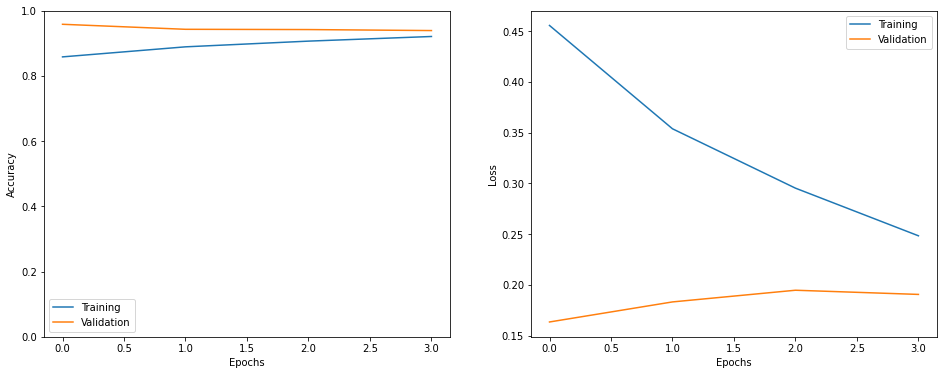

In [ ]:
show_history(h_vect)

In [ ]:
model_vect.save('ConVmodel.h5')

###Make the subnission file

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/2022 big_data/dataset/MBTI_test.csv', names = ['posts'])

In [ ]:
s = submission['posts'].values
s

array(['get accept ya bite well stop important open look work sorry summer give fi moralistic get talk conflict person like home yes try quickly tender differently interact relax bartender say though bar month young development short true dom discus field individual cognitive probably music te drain take slap get kind drive idea rather see drink happen think enjoy hollywood make plan collection want bartender car thank hate career line leap r answer associate disappear invite diverse daunt moralistic love trouble fi place appreciate thing support experience good enfp little tend post understand thing come community unwaveringly yet le people friend sling community spend seem moral type think meteorology still maybe realize know u aux mine like around think black paint huge class x talk along one child selfish applicable theatre also think look one say prone personal get text people arrive user istp weird want white surprise early something fun either curl lately read calm yeah old coul

In [ ]:
vect_test = vectorize_layer(s)
vect_test

<tf.Tensor: shape=(9337, 500), dtype=int64, numpy=
array([[   5,  350, 1352, ...,    0,    0,    0],
       [ 647, 3138,   23, ...,    0,    0,    0],
       [7631, 3035,  166, ...,    0,    0,    0],
       ...,
       [  17,  207,  519, ...,    0,    0,    0],
       [1830,  282,  263, ...,    0,    0,    0],
       [4104,  424,  158, ...,    0,    0,    0]])>

In [ ]:
pred = model_vect.predict(vect_test)

In [ ]:
pred.shape

In [ ]:
pred[2]

array([4.2477762e-08, 4.4554776e-01, 7.4050712e-07, 1.3946185e-07,
       4.1790820e-08, 4.3161976e-09, 3.7268744e-09, 2.1369769e-14,
       1.6666624e-03, 8.7212838e-06, 5.5252844e-01, 4.5894340e-06,
       3.5372871e-09, 7.9254142e-10, 2.4287647e-04, 1.3027207e-09],
      dtype=float32)

In [ ]:
a = np.zeros(16)
a[0] = 1
print(a)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
test = []
classes = le.classes_
pred = pred.tolist()
for i in range(len(pred)):
  a =  pred[i].index(max(pred[i]))
  mbti = classes[a]
  test.append(mbti)

In [ ]:
test

['ENFP',
 'INFJ',
 'INTJ',
 'INTJ',
 'INTP',
 'INFJ',
 'INFP',
 'INFJ',
 'ENFP',
 'INFJ',
 'ENTP',
 'INTP',
 'ENTP',
 'INFJ',
 'INTP',
 'INFJ',
 'INTP',
 'INFP',
 'INTJ',
 'INTP',
 'INFP',
 'INTJ',
 'ENTP',
 'INTJ',
 'ISTP',
 'INTJ',
 'INFJ',
 'INTP',
 'INTJ',
 'INFP',
 'INTJ',
 'INTJ',
 'INFP',
 'INTJ',
 'INTP',
 'INTJ',
 'ENFP',
 'INTP',
 'INFJ',
 'INTP',
 'ENFP',
 'INFJ',
 'ENTJ',
 'ENTP',
 'INFP',
 'INTP',
 'INFP',
 'INTJ',
 'INFJ',
 'INFJ',
 'ENTP',
 'ISTP',
 'INTJ',
 'INFP',
 'ISTP',
 'INTJ',
 'INFJ',
 'INTJ',
 'INFP',
 'INTP',
 'ENFP',
 'INTJ',
 'INFP',
 'INTJ',
 'INTJ',
 'INFJ',
 'INTJ',
 'ENTP',
 'INTJ',
 'ENTP',
 'INTP',
 'INTP',
 'ENFP',
 'ESTP',
 'INTJ',
 'ENTP',
 'INFP',
 'INFP',
 'ENFP',
 'INTJ',
 'INFJ',
 'INTP',
 'INFJ',
 'INFP',
 'INFP',
 'INTP',
 'ENTJ',
 'INFJ',
 'INTP',
 'INFP',
 'ENFP',
 'ENFP',
 'ENTP',
 'INFJ',
 'INTJ',
 'INTP',
 'ISTP',
 'INTP',
 'ENTJ',
 'INTP',
 'ENTJ',
 'INTP',
 'ENTP',
 'INFP',
 'INTP',
 'INFJ',
 'INTJ',
 'ENTP',
 'INTJ',
 'ENTP',
 'INFJ',
 

In [ ]:
df = pd.DataFrame(test)

In [ ]:
df.head()

,0
0,ENFP
1,INFJ
2,INTJ
3,INTJ
4,INTP


In [ ]:
df.to_csv('ConV_.csv')